##  TimeSerie Analysis - Data Science Specialization module
#### Part 3: Dynamic Time Warping analysis for unsupervised Stock clustering
The goal of this notebook is to evaluate TimeSeries similitudes for a large number of stocks (either manually selected or from the S&P500) and cluster those Timeseries using  Dynamic Time Warping into a given number (predefined) of clusters.  

Note: The S&P500 (Standard and Poor's 500) stock market index is tracking the stock performance of 500 large companies listed on exchanges in the United States.

============================

## Let'start by importing all required packages

In [129]:
# data manipulation
import numpy as np
np.set_printoptions(linewidth=1000)
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Financial market data handlers/loaders
import pandas_datareader.data as web

# Statistics modelization
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller, kpss 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import probplot, moment
# from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.arima_process import  arma_generate_sample
from arch import arch_model

# package pmdarima (conda install -c conda-forge pmdarima)
from pmdarima.arima import auto_arima

# Dynamic Time Warping (conda install -c conda-forge dtw-python)
from dtw import dtw, rabinerJuangStepPattern, dtwPlot

# Timeseries clustering (conda install -c conda-forge tslearn )
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler, TimeSeriesScalerMinMax
    
# visualization
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')

# Misc
import random
from tqdm import tqdm  
import warnings
warnings.simplefilter("ignore")

## Let's now load some TimeSerie data 

The S&P500 index tracks the stock performance of 500 large companies listed on exchanges in the United States.  It provides a convient way to gather the ISIN symbols required to read the TimeSeries and also a convenient organization of the company stock by sector of activities (Health Care, IT, Communication Services, Financials, etc).   

Alternatively a list of stock ISIN symbols can be provided manually. 

#### Let's first load the S&P500 stock list

In [89]:
# Get the list of SP500 stocks
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_list = pd.read_html(sp_url, header=0)[0]

# Display the reported sector of activities for info
sector_list = sp500_list["GICS Sector"].unique()
print("List of sectors:\n", sector_list)

# Display a few sock ISIN symbols for each sector
for sector in sector_list:
    sp500_sector = sp500_list[sp500_list["GICS Sector"] == sector]
    print(f"\nList of companies (only 10 first) in {sector} sector:\n",sp500_sector.Security.to_list()[:10], sep='')

# Overview of the data organization
sp500_list.head()

List of sectors:
 ['Industrials' 'Health Care' 'Information Technology' 'Communication Services' 'Consumer Staples' 'Consumer Discretionary' 'Utilities' 'Financials' 'Materials' 'Real Estate' 'Energy']

List of companies (only 10 first) in Industrials sector:
['3M', 'A. O. Smith', 'Alaska Air Group', 'Allegion', 'American Airlines Group', 'Ametek', 'Boeing', 'C.H. Robinson', 'Carrier Global', 'Caterpillar Inc.']

List of companies (only 10 first) in Health Care sector:
['Abbott', 'AbbVie', 'Abiomed', 'Agilent Technologies', 'Align Technology', 'AmerisourceBergen', 'Amgen', 'Baxter International', 'Becton Dickinson', 'Bio-Rad']

List of companies (only 10 first) in Information Technology sector:
['Accenture', 'Adobe Inc.', 'ADP', 'Akamai', 'AMD', 'Amphenol', 'Analog Devices', 'Ansys', 'Apple Inc.', 'Applied Materials']

List of companies (only 10 first) in Communication Services sector:
['Activision Blizzard', 'Alphabet Inc. (Class A)', 'Alphabet Inc. (Class C)', 'AT&T', 'Charter Commun

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


#### Let's now make a selection of which sector & stocks we would like to analyze & cluster

In [90]:
# Select ALL stocks from a sector of activity from the SP500
#
# 'Industrials', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Staples'
# 'Utilities', 'Financials', 'Materials', 'Real Estate', 'Energy', 'Consumer Discretionary' 
#
# Various combinations are also possible, just append the ISIN symbols to the list

sector = 'Industrials'  # See full list above
print("Selected Sector: ", sector)

symbol = sp500_list[sp500_list["GICS Sector"] == sector]["Symbol"].to_list()
print("Symbols: ", symbol[:20])

Selected Sector:  Industrials
Symbols:  ['MMM', 'AOS', 'ALK', 'ALLE', 'AAL', 'AME', 'BA', 'CHRW', 'CARR', 'CAT', 'CTAS', 'CPRT', 'CSX', 'CMI', 'DE', 'DAL', 'DOV', 'ETN', 'EMR', 'EFX']


#### Alternatively, select the stock ISIN manually
(https://finance.yahoo.com/lookup/index?s=isin)

In [91]:
# Select stocks MANUALLY - any stock which is monitored with Yahoo Finance is available
#
#### Various exchanges indexes
# symbol =["^FCHI", "^FTSE", "^GSPC", "^DJI", "^IXIC", "^GDAXI", "IMOEX.ME", "^N225", "^MXX", "^KLSE", "^HSI", "^BFX", "^N100"]

### Various cherry picked stocks
# symbol =["DIS", "UBER", "TSLA", "CRERF", "ZM", "TWTR", "AI.PA", "UBS", "NOVN.SW"]


#### Let's now read the TimeSerie data 
(period covered is limited to 2020-2022 but this is just an arbitrary choice, can be extended or shortened)

In [92]:
# We load the data as a Pandas DataFrame or Series (depending on data type or source)
data = web.DataReader(symbol, "yahoo" , start="2020", end="2022").squeeze().dropna()
data = data.Close.squeeze().dropna()

## Print some info
# print (data.info())
print(f"TimeSerie data shape: {data.shape}")
# print(f"TimeSerie data type: {type(data)}")

print("Period:",data.index[0],"-",data.index[-1])
print(data.head(1))

TimeSerie data shape: (452, 73)
Period: 2020-03-19 00:00:00 - 2021-12-31 00:00:00
Symbols            MMM        AOS    ALK       ALLE    AAL        AME         BA       CHRW  CARR         CAT   CTAS       CPRT        CSX         CMI          DE    DAL        DOV        ETN    EMR         EFX       EXPD       FAST     FDX        FTV       FBHS       GNRC          GD     GE         HON    HWM         HII         IEX         ITW     IR       JBHT          J    JCI         LHX       LDOS         LMT        MAS   NLSN        NDSN         NSC         NOC        ODFL   OTIS       PCAR          PH    PNR    PWR        RTX   RSG        RHI         ROK        ROL        ROP         SNA        LUV        SWK         TDY        TXT         TT         TDG         UNP        UAL    UPS        URI        VRSK        WAB         WM         GWW        XYL
Date                                                                                                                                                 

#### Let's now have a general overview of the TimeSeries, are they similar of fairly different? 

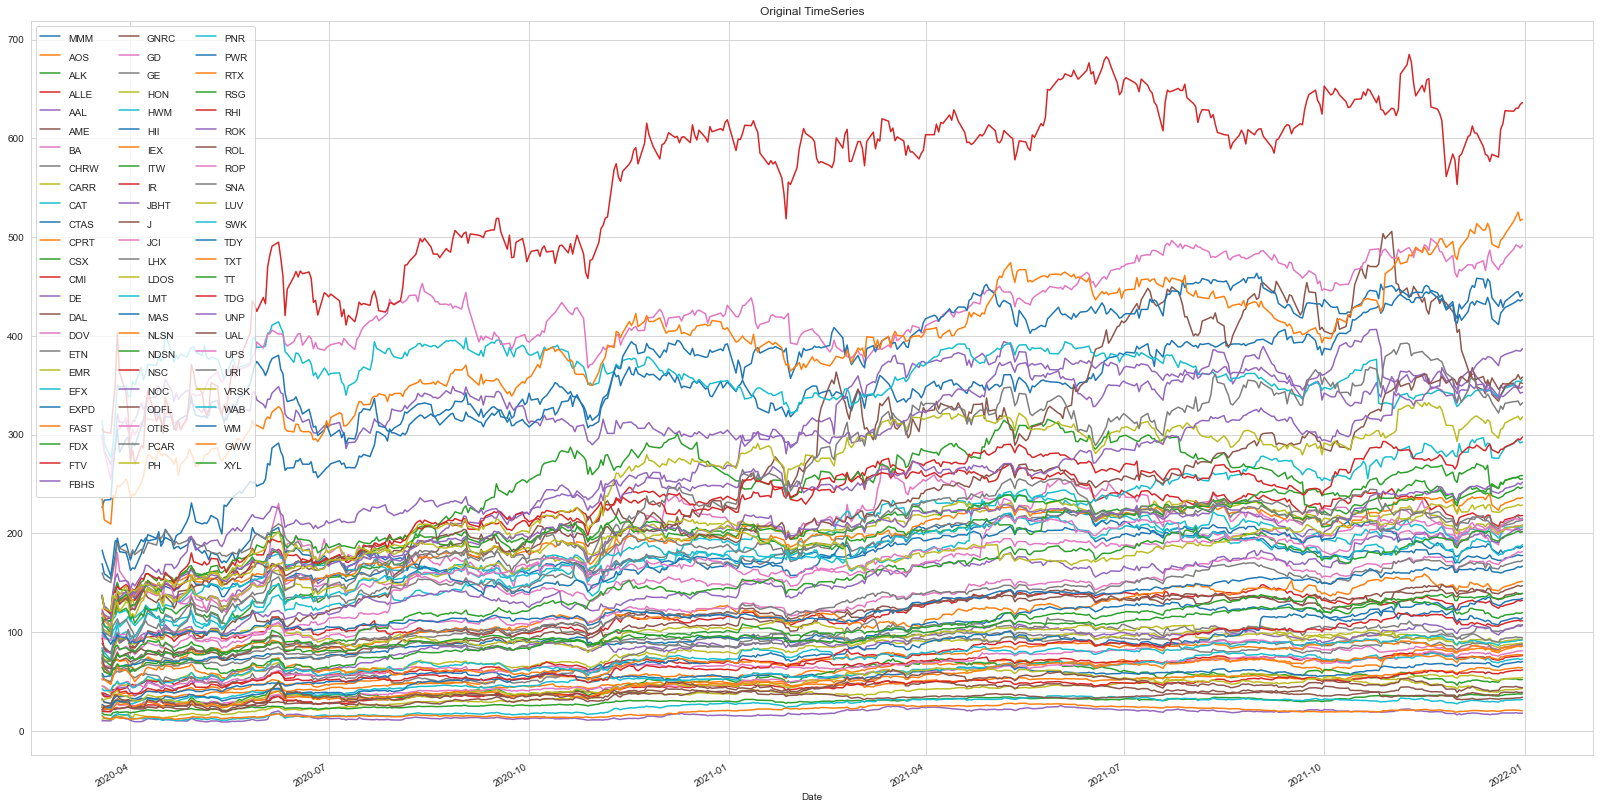

In [93]:
# Plot TimeSerie differentiation
fig, axes = plt.subplots(figsize=(28, 15))
data.plot(ax=axes, title="Original TimeSeries")
plt.legend(ncol=3,handleheight=2.4, labelspacing=0.05)
plt.show()

#### Let's check a stock at random

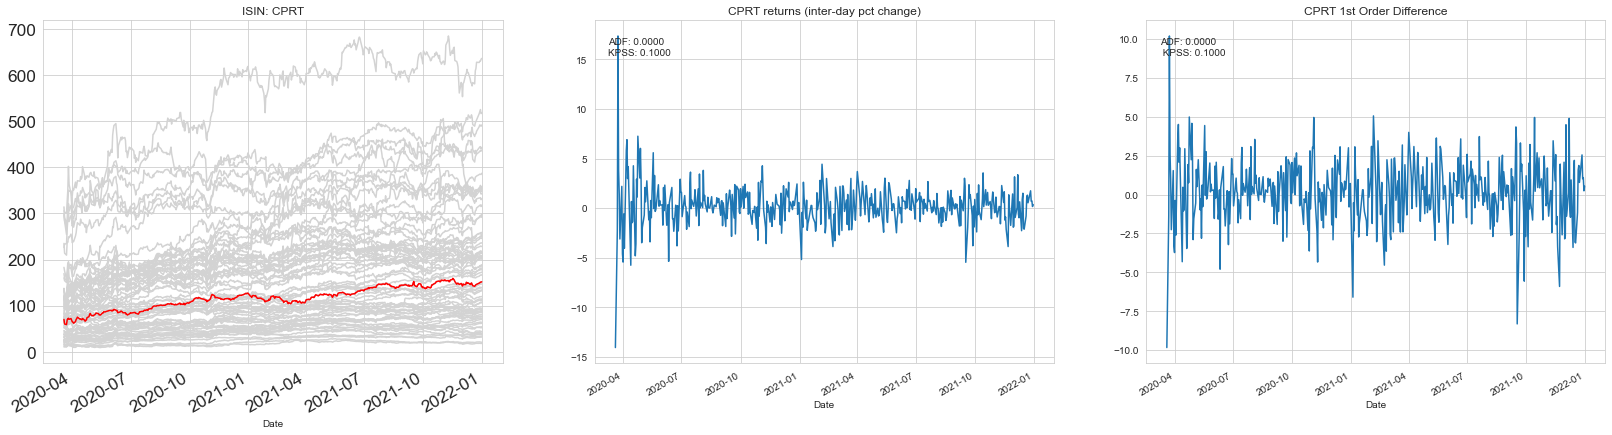

In [94]:
# Pick a stock ISIN at random
rnd_stock_no = random.randint(1,data.shape[1])
stock = data[symbol[rnd_stock_no]]    
stock_name = stock.name

# Calculating returns and 1st difference of the stock values
returns = 100*stock.pct_change().dropna()
data_diff = stock.diff().dropna()

# Plot TimeSerie differentiation
fig, axes = plt.subplots(1,3, figsize=(28, 7))
data.plot(ax=axes[0], title="ISIN: "+stock_name, color="lightgrey")
stock.plot(ax=axes[0], fontsize='xx-large', color="red")
axes[0].get_legend().remove()

returns.plot(ax=axes[1], title=stock_name+" returns (inter-day pct change)")
axes[1].text(x=.03, y=.9, s=f'ADF: {adfuller(returns)[1]:.4f}\nKPSS: {kpss(returns, nlags=5)[1]:.4f}', transform=axes[1].transAxes)

data_diff.plot(ax=axes[2], title=stock_name+" 1st Order Difference")
axes[2].text(x=.03, y=.9, s=f'ADF: {adfuller(data_diff)[1]:.4f}\n KPSS: {kpss(data_diff, nlags=10)[1]:.4f}', transform=axes[2].transAxes)

fig.align_ylabels(axes)
plt.show()

#### We now need to preprocess the TimeSeries for the DTW and clustering algorithms to run efficiently
(this will produce a numpy array) 

In [96]:
# Scale all TimeSeries
X_train = TimeSeriesScalerMeanVariance().fit_transform(data.T)
# X_train = TimeSeriesScalerMinMax().fit_transform(data)

# Make time series shorter
# X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
# sz = X_train.shape[1]

print(X_train.shape)
# print(X_train[:10,0])

(73, 452, 1)


#### Let's now generate a DataFrame of the preprocessed TimeSerie for vizualization

In [97]:
# Create a Dataframe for convenience
N , Sz, _ = X_train.shape   
X_train_df = pd.DataFrame(X_train.reshape(N , Sz).T, index=data.index)
X_train_df.columns = data.columns

X_train_df.head(5)

Symbols,MMM,AOS,ALK,ALLE,AAL,AME,BA,CHRW,CARR,CAT,CTAS,CPRT,CSX,CMI,DE,DAL,DOV,ETN,EMR,EFX,EXPD,FAST,FDX,FTV,FBHS,GNRC,GD,GE,HON,HWM,HII,IEX,ITW,IR,JBHT,J,JCI,LHX,LDOS,LMT,MAS,NLSN,NDSN,NSC,NOC,ODFL,OTIS,PCAR,PH,PNR,PWR,RTX,RSG,RHI,ROK,ROL,ROP,SNA,LUV,SWK,TDY,TXT,TT,TDG,UNP,UAL,UPS,URI,VRSK,WAB,WM,GWW,XYL
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,-2.078408,-1.947372,-2.009567,-1.447693,-1.542040,-2.278533,-2.893923,-2.976082,-2.099857,-1.938605,-2.421220,-1.948361,-2.290942,-2.923881,-1.868964,-1.981155,-2.113816,-1.769776,-2.149642,-1.694345,-2.116911,-2.352960,-2.116775,-3.228365,-2.763507,-1.564860,-1.970192,-1.354423,-2.210730,-1.197086,-0.707515,-2.573174,-2.686961,-2.303563,-2.280321,-1.665326,-1.690149,-1.836032,-3.050260,-2.459632,-3.065504,-0.950515,-3.022658,-2.400740,-1.331472,-1.997150,-1.903806,-3.305364,-2.520910,-2.196090,-1.734696,-1.834176,-1.586313,-1.583326,-2.559828,-2.508363,-2.598632,-1.897650,-1.493294,-2.980566,-2.932351,-1.571470,-1.728771,-2.406805,-3.007384,-2.316863,-1.887300,-2.015427,-2.455230,-2.475646,-1.280805,-2.400260,-1.579447
2020-03-20,-2.776218,-2.122505,-2.057628,-2.131449,-1.521424,-2.551750,-2.969806,-2.992440,-2.040904,-2.126162,-2.543075,-2.360367,-2.650554,-2.983790,-1.962150,-2.001379,-2.276171,-2.016769,-2.268755,-1.887213,-2.267129,-2.859007,-2.127335,-3.273934,-2.827745,-1.596736,-2.128303,-1.340604,-2.403018,-1.533179,-1.185900,-2.815620,-3.093257,-2.343073,-2.400796,-2.056544,-1.761012,-2.122697,-3.541712,-3.567858,-3.470728,-1.282155,-3.263956,-2.706219,-1.771750,-1.925389,-1.923209,-3.733377,-2.550850,-2.243599,-1.800400,-1.901530,-1.724553,-1.721238,-2.731842,-2.601339,-2.952462,-2.070505,-1.384172,-3.124985,-2.792750,-1.758377,-1.884754,-2.439208,-3.148192,-1.972842,-1.961942,-2.102244,-3.062372,-2.620687,-1.353168,-2.725724,-1.781462
2020-03-23,-3.164382,-2.051618,-2.021195,-2.387555,-1.551203,-2.801714,-2.671612,-3.065507,-2.136015,-2.217318,-2.820830,-2.417730,-2.805173,-3.380867,-1.967720,-1.891414,-2.302593,-2.251938,-2.639671,-1.907567,-2.222113,-2.938610,-2.115413,-3.620064,-2.929263,-1.644884,-2.417520,-1.482241,-2.660196,-1.696054,-1.438053,-2.880108,-3.389410,-2.353938,-2.456158,-2.170794,-1.846411,-2.302215,-3.784547,-4.263272,-3.723504,-1.648704,-3.519718,-2.823133,-2.255406,-1.890708,-2.311280,-4.007627,-2.631857,-2.306719,-1.847636,-2.316605,-2.021264,-1.757008,-2.858622,-3.132852,-3.557917,-2.174314,-1.203312,-3.373038,-2.778828,-1.795640,-1.998711,-2.448949,-3.288630,-1.785874,-2.003678,-2.093231,-3.214778,-2.591213,-1.843732,-2.791585,-1.925128
2020-03-24,-2.343266,-1.977395,-1.642909,-2.005812,-0.710517,-2.330367,-2.051615,-3.031700,-2.123438,-1.980312,-2.562947,-1.990650,-2.256660,-2.751969,-1.795389,-1.301144,-1.976840,-1.810503,-2.255795,-1.728927,-1.868342,-2.485158,-1.974387,-2.853149,-2.611516,-1.588976,-2.119693,-1.171331,-2.194359,-1.287573,-0.900283,-2.691930,-2.634201,-2.066504,-2.214512,-1.890363,-1.733757,-1.745333,-2.681672,-3.679259,-3.190589,-1.356337,-2.875709,-2.306337,-1.865339,-1.716102,-2.311280,-3.194058,-2.332949,-2.024376,-1.712676,-1.669899,-1.727363,-1.541091,-2.418316,-2.785741,-2.958128,-1.908273,-0.806230,-2.763269,-2.191451,-1.717565,-1.855620,-2.208908,-2.740551,-1.064713,-1.913786,-1.913894,-2.415515,-2.217363,-1.646379,-2.343304,-1.688190
2020-03-25,-2.408513,-1.944037,-1.570817,-1.732189,-0.373784,-2.182132,-1.178954,-3.169109,-1.985882,-1.897148,-2.277489,-1.881368,-2.184598,-2.657041,-1.766493,-0.769017,-1.773461,-1.699159,-2.051513,-1.688219,-1.804242,-2.647207,-2.003853,-2.856057,-2.494512,-1.571786,-1.814821,-0.981330,-1.892533,-1.155721,-0.331877,-2.714131,-2.409679,-1.980570,-2.018131,-1.727644,-1.687121,-1.210069,-1.574459,-2.195838,-2.864846,-1.282155,-2.854669,-2.302222,-1.623511,-1.547876,-2.232889,-2.966855,-2.149978,-1.888634,-1.612876,-1.153519,-1.713314,-1.511354,-2.155627,-2.974793,-2.909860,-1.827398,-0.630422,-2.496161,-1.793156,-1.537164,-1.641370,-1.966283,

#### ... and compare the data to the original TimeSeries

In [98]:
data.head()

Symbols,MMM,AOS,ALK,ALLE,AAL,AME,BA,CHRW,CARR,CAT,CTAS,CPRT,CSX,CMI,DE,DAL,DOV,ETN,EMR,EFX,EXPD,FAST,FDX,FTV,FBHS,GNRC,GD,GE,HON,HWM,HII,IEX,ITW,IR,JBHT,J,JCI,LHX,LDOS,LMT,MAS,NLSN,NDSN,NSC,NOC,ODFL,OTIS,PCAR,PH,PNR,PWR,RTX,RSG,RHI,ROK,ROL,ROP,SNA,LUV,SWK,TDY,TXT,TT,TDG,UNP,UAL,UPS,URI,VRSK,WAB,WM,GWW,XYL
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,137.509995,36.849998,24.180000,94.160004,10.29,69.010002,97.709999,64.059998,12.00,103.010002,183.000000,69.989998,18.336666,118.550003,119.660004,21.510000,70.800003,72.449997,46.020000,115.410004,58.009998,32.299999,111.680000,38.535564,37.720001,88.599998,118.029999,51.840000,118.959999,15.85,169.470001,123.360001,136.330002,20.010000,84.089996,74.690002,26.080000,160.139999,75.910004,314.200012,32.580002,15.14,114.580002,136.330002,296.910004,108.066666,45.250000,56.029999,104.230003,24.480000,26.980000,52.712399,74.000000,38.200001,135.080002,23.733334,300.010010,107.029999,30.860001,83.769997,226.240005,25.450001,81.730003,305.769989,121.650002,21.280001,96.250000,77.709999,136.479996,42.619999,99.849998,234.979996,64.459999
2020-03-20,124.889999,34.750000,23.559999,82.839996,10.38,63.369999,95.010002,63.910000,12.75,95.500000,175.089996,60.150002,16.623333,116.480003,111.629997,21.350000,66.129997,64.930000,44.090000,105.650002,54.939999,28.740000,111.059998,38.142258,36.599998,84.779999,113.989998,52.160000,112.500000,13.25,159.320007,116.480003,125.779999,19.610001,80.629997,65.650002,24.910000,154.039993,72.510002,291.220001,29.469999,13.62,107.239998,123.709999,284.019989,112.453331,45.000000,52.299999,102.430000,23.780001,25.129999,51.938328,71.540001,35.000000,126.790001,23.333332,283.149994,99.870003,31.940001,79.449997,233.660004,22.290001,75.680000,302.510010,117.839996,24.500000,93.459999,70.099998,124.250000,40.750000,98.309998,213.779999,59.889999
2020-03-23,117.870003,35.599998,24.030001,78.599998,10.25,58.209999,105.620003,63.240002,11.54,91.849998,157.059998,58.779999,15.886667,102.760002,111.150002,22.219999,65.370003,57.770000,38.080002,104.620003,55.860001,28.180000,111.760002,35.154812,34.830002,79.010002,106.599998,48.880001,103.860001,11.99,153.970001,114.650002,118.089996,19.500000,79.040001,63.009998,23.500000,150.220001,70.830002,276.799988,27.530001,11.94,99.459999,118.879997,269.859985,114.573334,40.000000,49.910000,97.559998,22.850000,23.799999,47.168030,66.260002,34.169998,120.680000,21.046667,254.300003,95.570000,33.730000,72.029999,234.399994,21.660000,71.260002,301.529999,114.040001,26.250000,91.900002,70.889999,121.180000,41.130001,87.870003,209.490005,56.639999
2020-03-24,132.720001,36.490002,28.910000,84.919998,13.92,67.940002,127.680000,63.549999,11.70,101.339996,173.800003,68.980003,18.500000,124.489998,126.000000,26.889999,74.739998,71.209999,44.299999,113.660004,63.090000,31.370001,120.040001,41.774059,40.369999,85.709999,114.209999,56.080002,119.510002,15.15,165.380005,119.989998,137.699997,22.410000,85.980003,69.489998,25.360001,162.070007,78.459999,288.910004,31.620001,13.28,119.050003,140.229996,281.279999,125.246666,40.000000,57.000000,115.529999,27.010000,27.600000,54.600376,71.489998,39.180000,141.899994,22.540001,282.880005,106.589996,37.660000,90.269997,265.619995,22.980000,76.809998,325.679993,128.869995,33.000000,95.260002,86.610001,137.279999,45.950001,92.070000,238.690002,62.000000
2020-03-25,131.539993,36.889999,29.840000,89.449997,15.39,71.000000,158.729996,62.290001,13.45,104.669998,192.330002,71.589996,18.843332,127.769997,128.490005,31.100000,80.589996,74.599998,47.610001,115.720001,64.400002,30.230000,118.309998,41.748955,42.410000,87.769997,122.000000,60.480000,129.649994,16.17,177.440002,119.360001,143.529999,23.280001,91.620003,73.250000,26.129999,173.460007,86.120003,319.670013,34.119999,13.62,119.690002,140.399994,288.359985,135.529999,41.009998,58.980000,126.529999,29.010000,30.410000,60.534927,71.739998,39.869999,154.559998,21.726667,285.179993,109.940002,39.400002,98.

#### Let's plot a stock Timeserie at random using the raw and transformed data on different axes.

Stock selected:  AAL


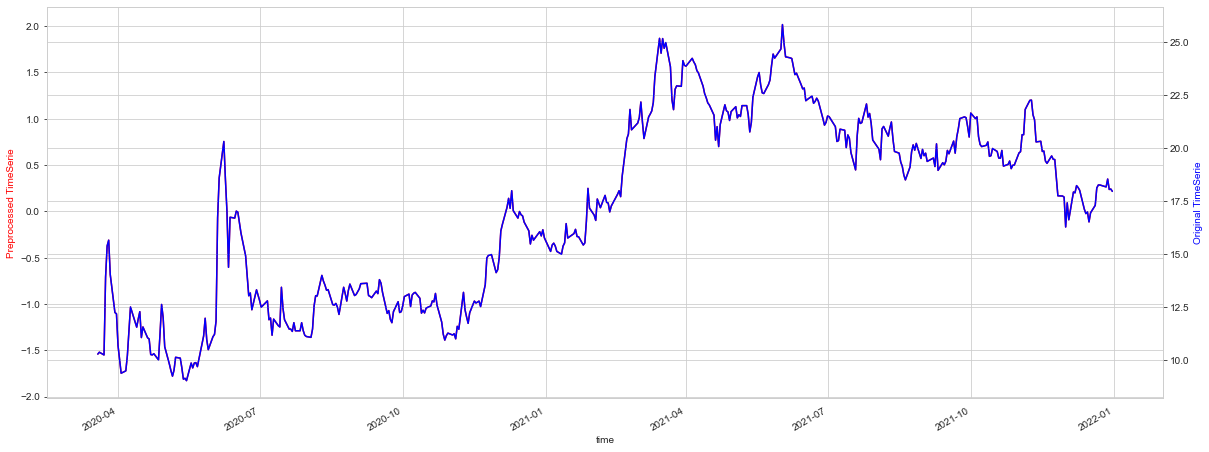

In [99]:
# Pick a stock ISIN at random
rnd_stock_no = random.randint(1,data.shape[1])
stock_name = X_train_df.columns[rnd_stock_no] 
print("Stock selected: ", stock_name)

# Creating plot with dataset_1
fig, ax1 = plt.subplots(figsize=(20,8))
 
X_train_df[stock_name].plot(ax=ax1, color = 'red')
ax1.set_xlabel('time')
ax1.set_ylabel('Preprocessed TimeSerie', color = 'red')
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
data[stock_name].plot(ax=ax2, color = 'blue')
ax2.set_ylabel('Original TimeSerie', color = 'blue')

plt.show()


Comments:   
- Note that the data collapses onto the same curve (as expected).  

### So, what's Dynamic Time Warping anyway?
Well, let's illustrate this with a few plots...   

First, let's pick 2 Timeseries at random.

Serie 1 selected:  AOS
Serie 2 selected:  SNA


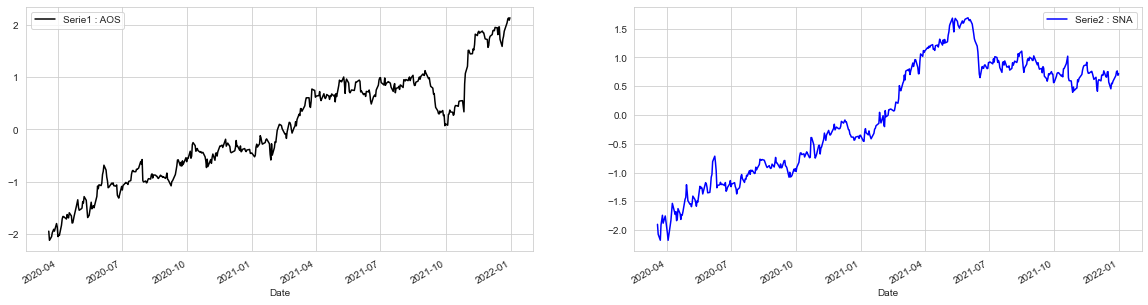

In [128]:
# First let's pick 2 Series at random
rnd_stock_no = random.randint(1,data.shape[1])
serie1_name = X_train_df.columns[rnd_stock_no] 
print("Serie 1 selected: ", serie1_name)
rnd_stock_no = random.randint(1,data.shape[1])
serie2_name = X_train_df.columns[rnd_stock_no] 
print("Serie 2 selected: ", serie2_name)

# Finally we plot some illustration graphs
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(20,5))
X_train_df[serie1_name].plot(ax=ax1, color="black")
ax1.legend(["Serie1 : "+serie1_name])
X_train_df[serie2_name].plot(ax=ax2, color="blue")
ax2.legend(["Serie2 : "+serie2_name])
plt.show()

Next, let's evaluate the distance cost matrix and trace back from high to low costs.    
This is all done through the "dtw" function of the dtw package.

In [135]:
# compute the DTW 
alignment = dtw(X_train_df[serie1_name], X_train_df[serie2_name], keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))

print("Evaluated distance metric: ",alignment.distance)


Evaluated distance metric:  104.70815217133362


Then let's plot an overview of the DTW for the 2 series.    
Note: Serie2 is displayed with an offset for vizualization purpose

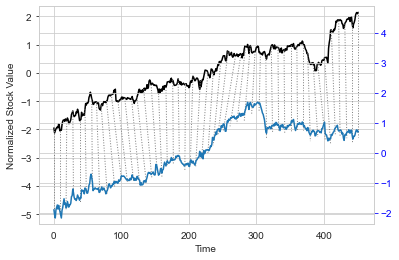

<AxesSubplot:xlabel='Time', ylabel='Normalized Stock Value'>

In [133]:
# Plot with the Rabiner-Juang type VI-c unsmoothed recursion
alignment.plot(type="twoway",offset=-3, xlab="Time", ylab="Normalized Stock Value")


and let's plot the cost matrix with the traceback path... 

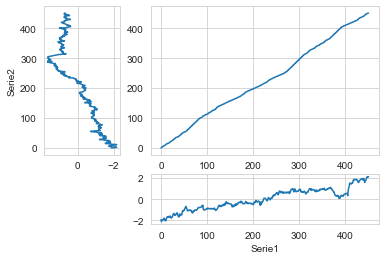

<AxesSubplot:>

In [137]:
alignment.plot(type="threeway", xlab="Serie1", ylab="Serie2")

.. and again the tracback path with a color contour plot of the cost matrix. 

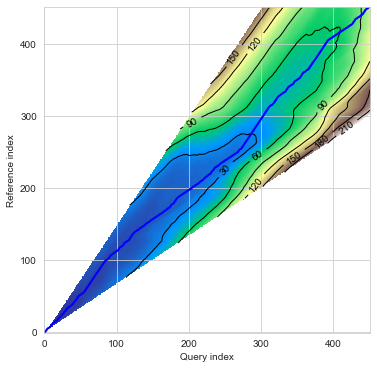

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [138]:
alignment.plot(type="density")

Comments:  
- Dynamic Time Warping is an algorithm for measuring similarity between two temporal sequences.  
- DTW is a method that calculates an optimal match between two given sequences (e.g. time series)   
- DTW return a similitude metric (distance) which can be used as a metric in a clustering algorithm.

### Let's now create a clustering model using the DTW metric

In [73]:
seed = 246
N_clusters=3

sz = X_train.shape[1]
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=N_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)

y_pred = sdtw_km.fit_predict(X_train)

Soft-DTW k-means
498.555 --> 73.412 --> 72.579 --> 72.400 --> 72.399 --> 72.458 --> 72.346 --> 72.374 --> 72.301 --> 72.360 --> 72.278 --> 72.299 --> 72.229 --> 72.255 --> 72.190 --> 72.209 --> 72.153 --> 72.180 --> 72.142 --> 72.159 --> 72.116 --> 72.145 --> 72.109 --> 72.130 --> 72.096 --> 72.122 --> 72.087 --> 72.108 --> 72.075 --> 72.099 --> 72.067 --> 72.088 --> 72.054 --> 72.077 --> 72.044 --> 72.065 --> 72.033 --> 72.055 --> 72.025 --> 72.045 --> 72.018 --> 72.040 --> 72.014 --> 72.033 --> 72.010 --> 72.037 --> 72.013 --> 72.017 --> 71.978 --> 71.987 --> 


#### and finally plot the stock TimeSeries by clusters

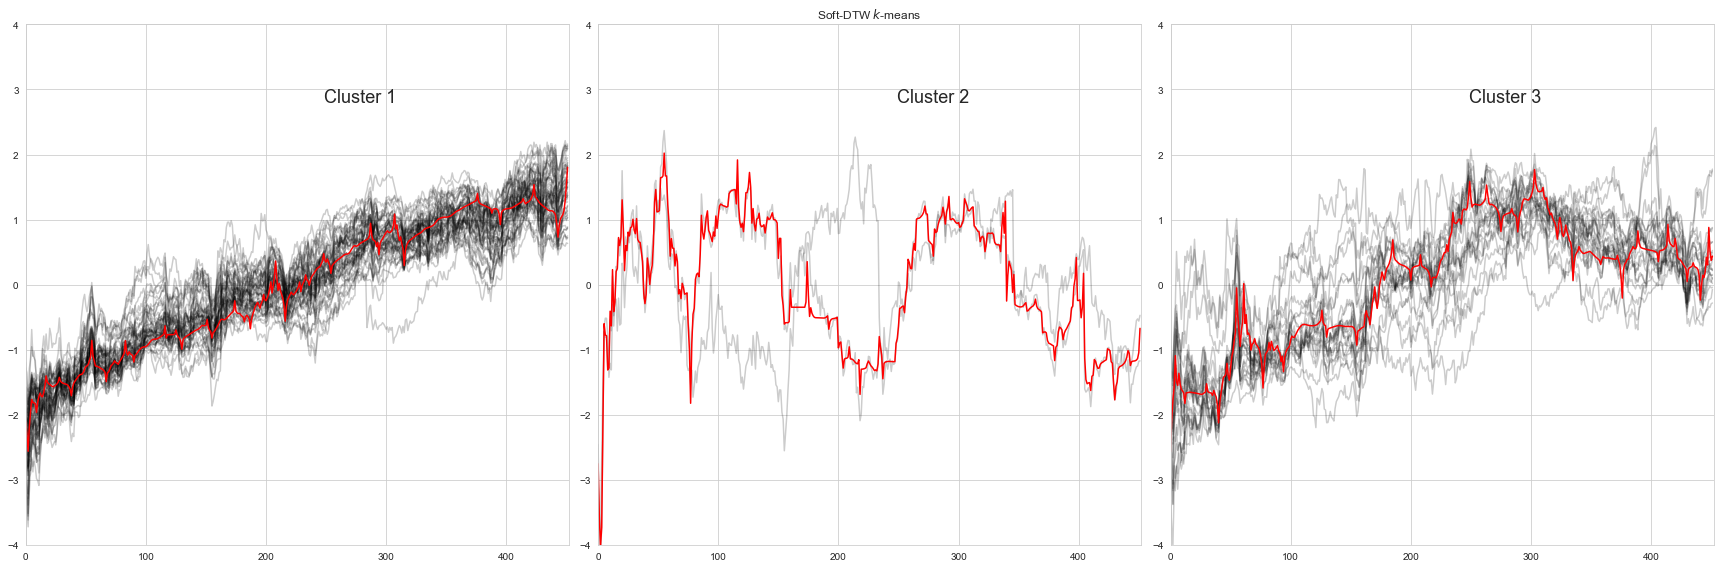

In [139]:
fig = plt.figure(figsize=(24,8))

for yi in range(3):
    plt.subplot(1, 3, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes, size=18)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

Comments:   
- The centroid TimeSerie is plotted in red.   
- All other TimeSeries (in grey) are similar (by Dynamic Time Warping) to the centroid.   
- The number of cluster was chosen arbitrarily and just for illustration purpose.   
- Without making a very deep analysis we can see see cluster1 seems to capture increasing stocks, cluster2 captures fluctuating/stagnating stocks, cluster3 captures increasing then decreasing stocks...  

#### and list the stocks by clusters

In [140]:
for cluster in range(N_clusters):
    print ("\nCLUSTER ",cluster+1)    
    for xx in X_train_df.columns[y_pred == cluster]:
        print(xx+", ", end='')
        


CLUSTER  1
AOS, AME, CARR, CTAS, CPRT, CSX, DE, DOV, ETN, EMR, EFX, EXPD, FAST, FTV, FBHS, GNRC, GD, HWM, IEX, ITW, IR, JBHT, J, JCI, MAS, NDSN, NSC, ODFL, OTIS, PH, PNR, PWR, RTX, RSG, RHI, ROK, ROP, SNA, TDY, TXT, TT, UNP, UPS, URI, VRSK, WAB, WM, GWW, XYL, 
CLUSTER  2
LDOS, LMT, 
CLUSTER  3
MMM, ALK, ALLE, AAL, BA, CHRW, CAT, CMI, DAL, FDX, GE, HON, HII, LHX, NLSN, NOC, PCAR, ROL, LUV, SWK, TDG, UAL, 